In [3]:
import pandas as pd
import seaborn as sns
df_low_level_audio_feautures = pd.read_csv("../../data/raw/low_level_audio_features.csv")
df_spotify_tracks = pd.read_csv("../../data/raw/spotify_tracks.csv")
#df_spotify_albums = pd.read_csv("/work/spotify_albums.csv")
#df_spotify_artists = pd.read_csv("/work/spotify_artists.csv")
#df_features = pd.read_csv("/work/lyrics_features.csv")


In [4]:
df_m1 =df_spotify_tracks.copy()
df_m1.drop("Unnamed: 0",inplace=True,axis=1)
df_m1.drop("analysis_url",inplace=True,axis=1)
df_m1.drop("available_markets",inplace=True,axis=1)
df_m1.drop("disc_number",inplace=True,axis=1)
df_m1.drop("href",inplace=True,axis=1)
df_m1.drop("id",inplace=True,axis=1)
df_m1.drop("lyrics",inplace=True,axis=1)
df_m1.drop("playlist",inplace=True,axis=1)
df_m1.drop("preview_url",inplace=True,axis=1)
df_m1.drop("track_number",inplace=True,axis=1)
df_m1.drop("uri",inplace=True,axis=1)
df_m1.drop("type",inplace=True,axis=1)
df_m1.drop("track_name_prev",inplace=True,axis=1)
df_m1.drop("track_href",inplace=True,axis=1)
df_m1.drop("artists_id",inplace=True,axis=1)
df_m1.drop("album_id",inplace=True,axis=1)
df_m1.drop("name",inplace=True,axis=1)
df_m1.drop("country",inplace=True,axis=1)

df_m1.columns
print(len(df_m1.columns))
df_m1.head()

14


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
0,0.294,0.698,235584.0,0.606,0.000003,10.0,0.151,-7.447,0.0,28.0,0.0262,115.018,4.0,0.6220
1,0.863,0.719,656960.0,0.308,0.000000,6.0,0.253,-10.340,1.0,31.0,0.9220,115.075,3.0,0.5890
2,0.750,0.466,492840.0,0.931,0.000000,4.0,0.938,-13.605,0.0,31.0,0.9440,79.565,4.0,0.0850
3,0.763,0.719,316578.0,0.126,0.000000,3.0,0.113,-20.254,0.0,14.0,0.9380,112.822,3.0,0.5330
4,0.770,0.460,558880.0,0.942,0.000000,7.0,0.917,-13.749,1.0,32.0,0.9430,81.260,4.0,0.0906


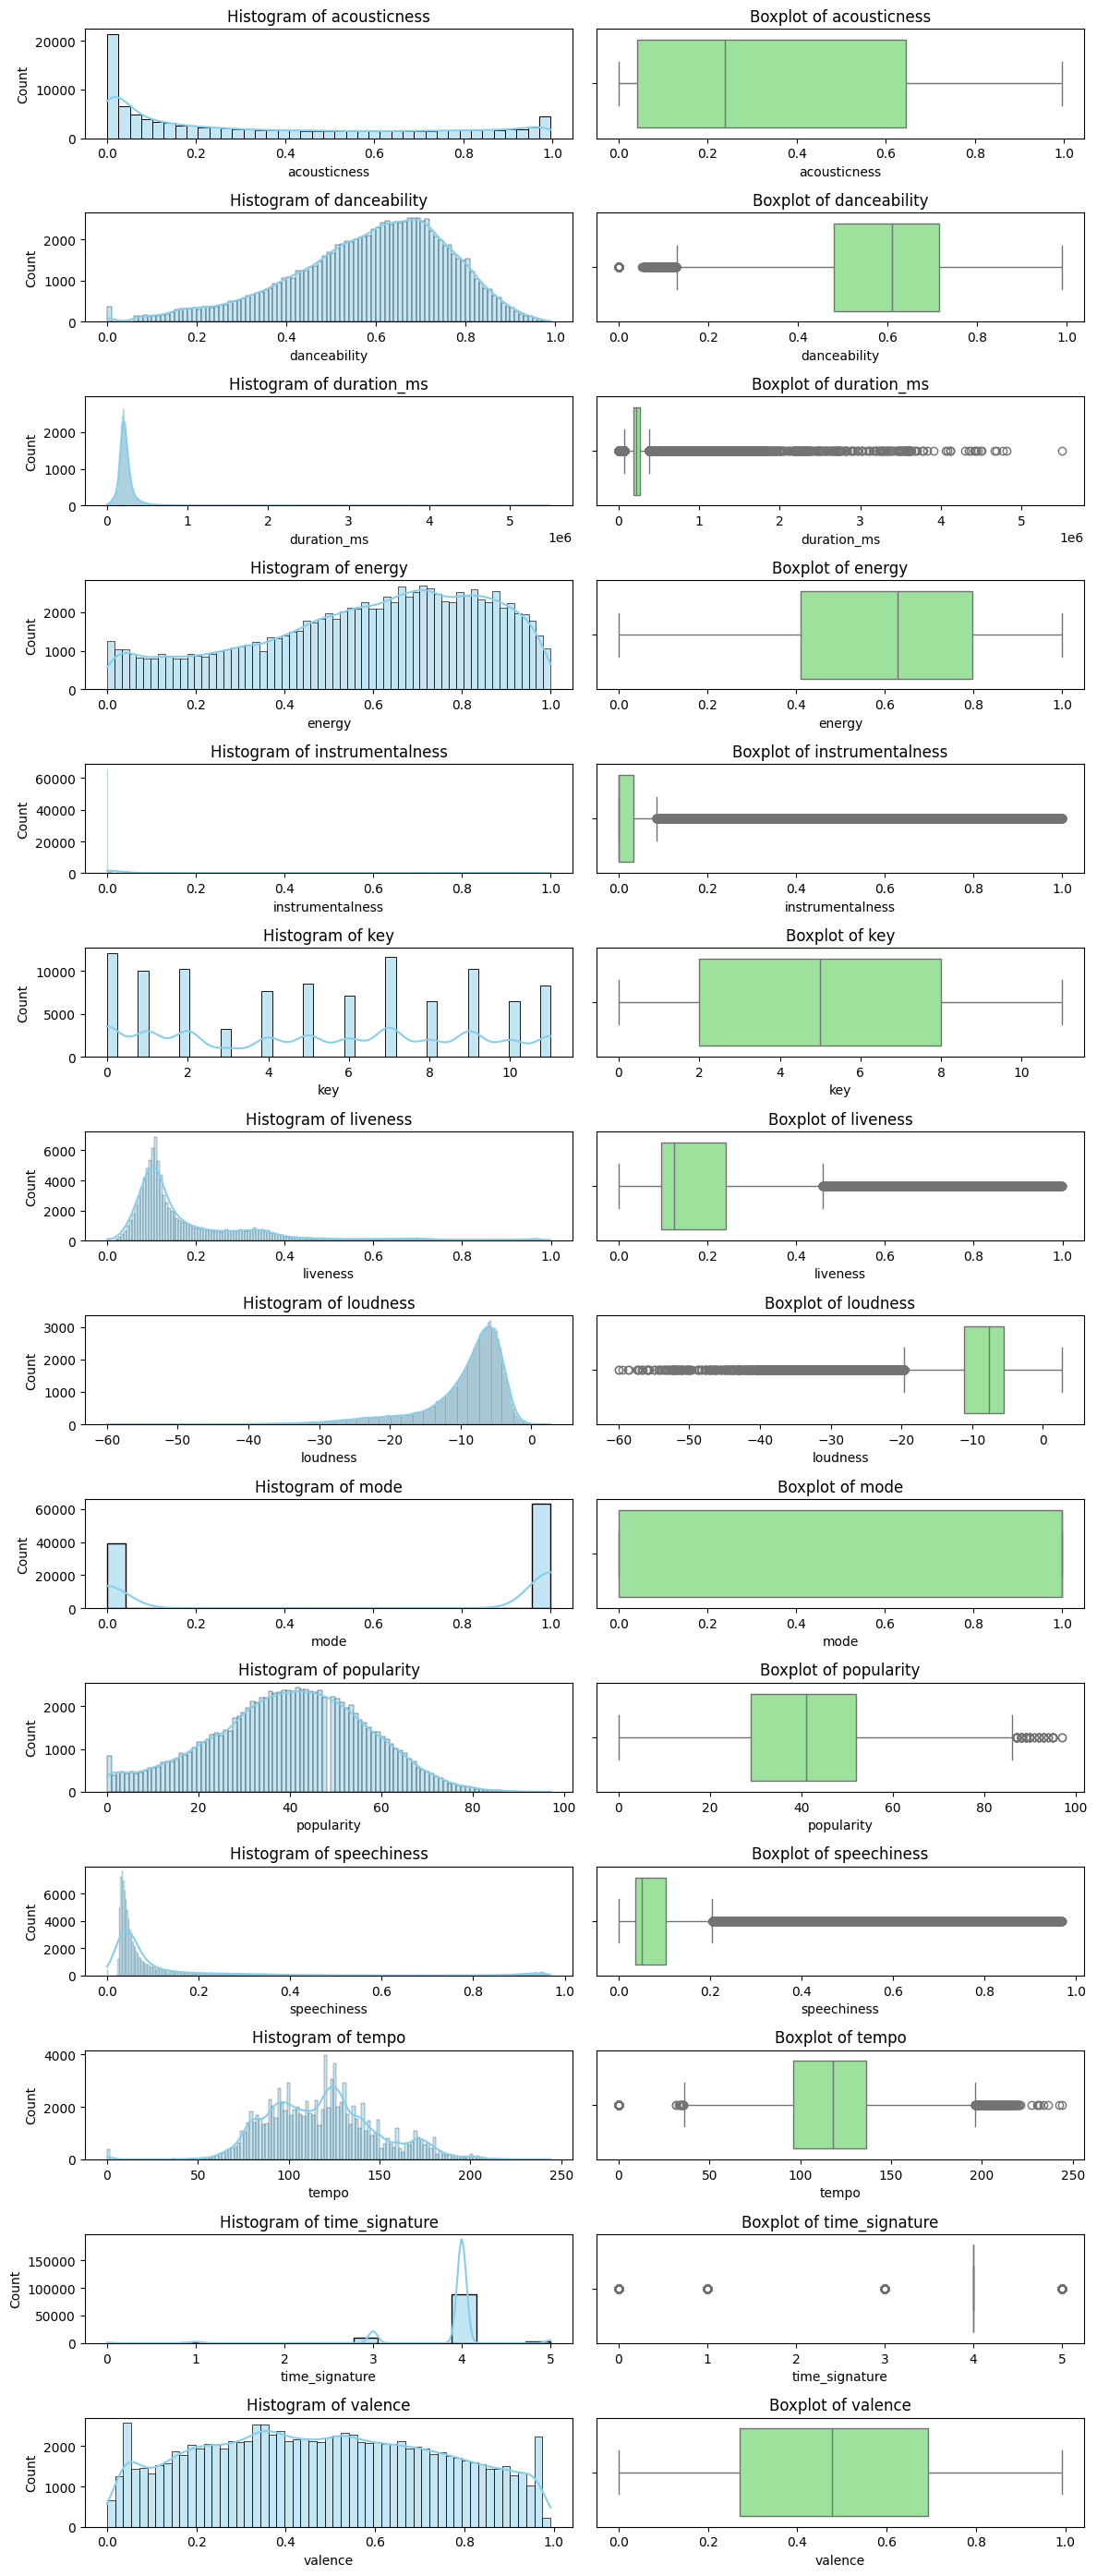

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def makeEdaPlots(df):
    # Assuming df is your DataFrame and only numerical columns are considered
    numerical_columns = df.select_dtypes(include='number').columns

    # Set up the size of the entire plot area
    num_cols = len(numerical_columns)
    fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(12, 2 * num_cols))

    for i, col in enumerate(numerical_columns):
        # Histogram
        sns.histplot(df[col], kde=True, ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'Histogram of {col}')

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[i, 1], color='lightgreen')
        axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()
makeEdaPlots(df_m1)

trying some transformations

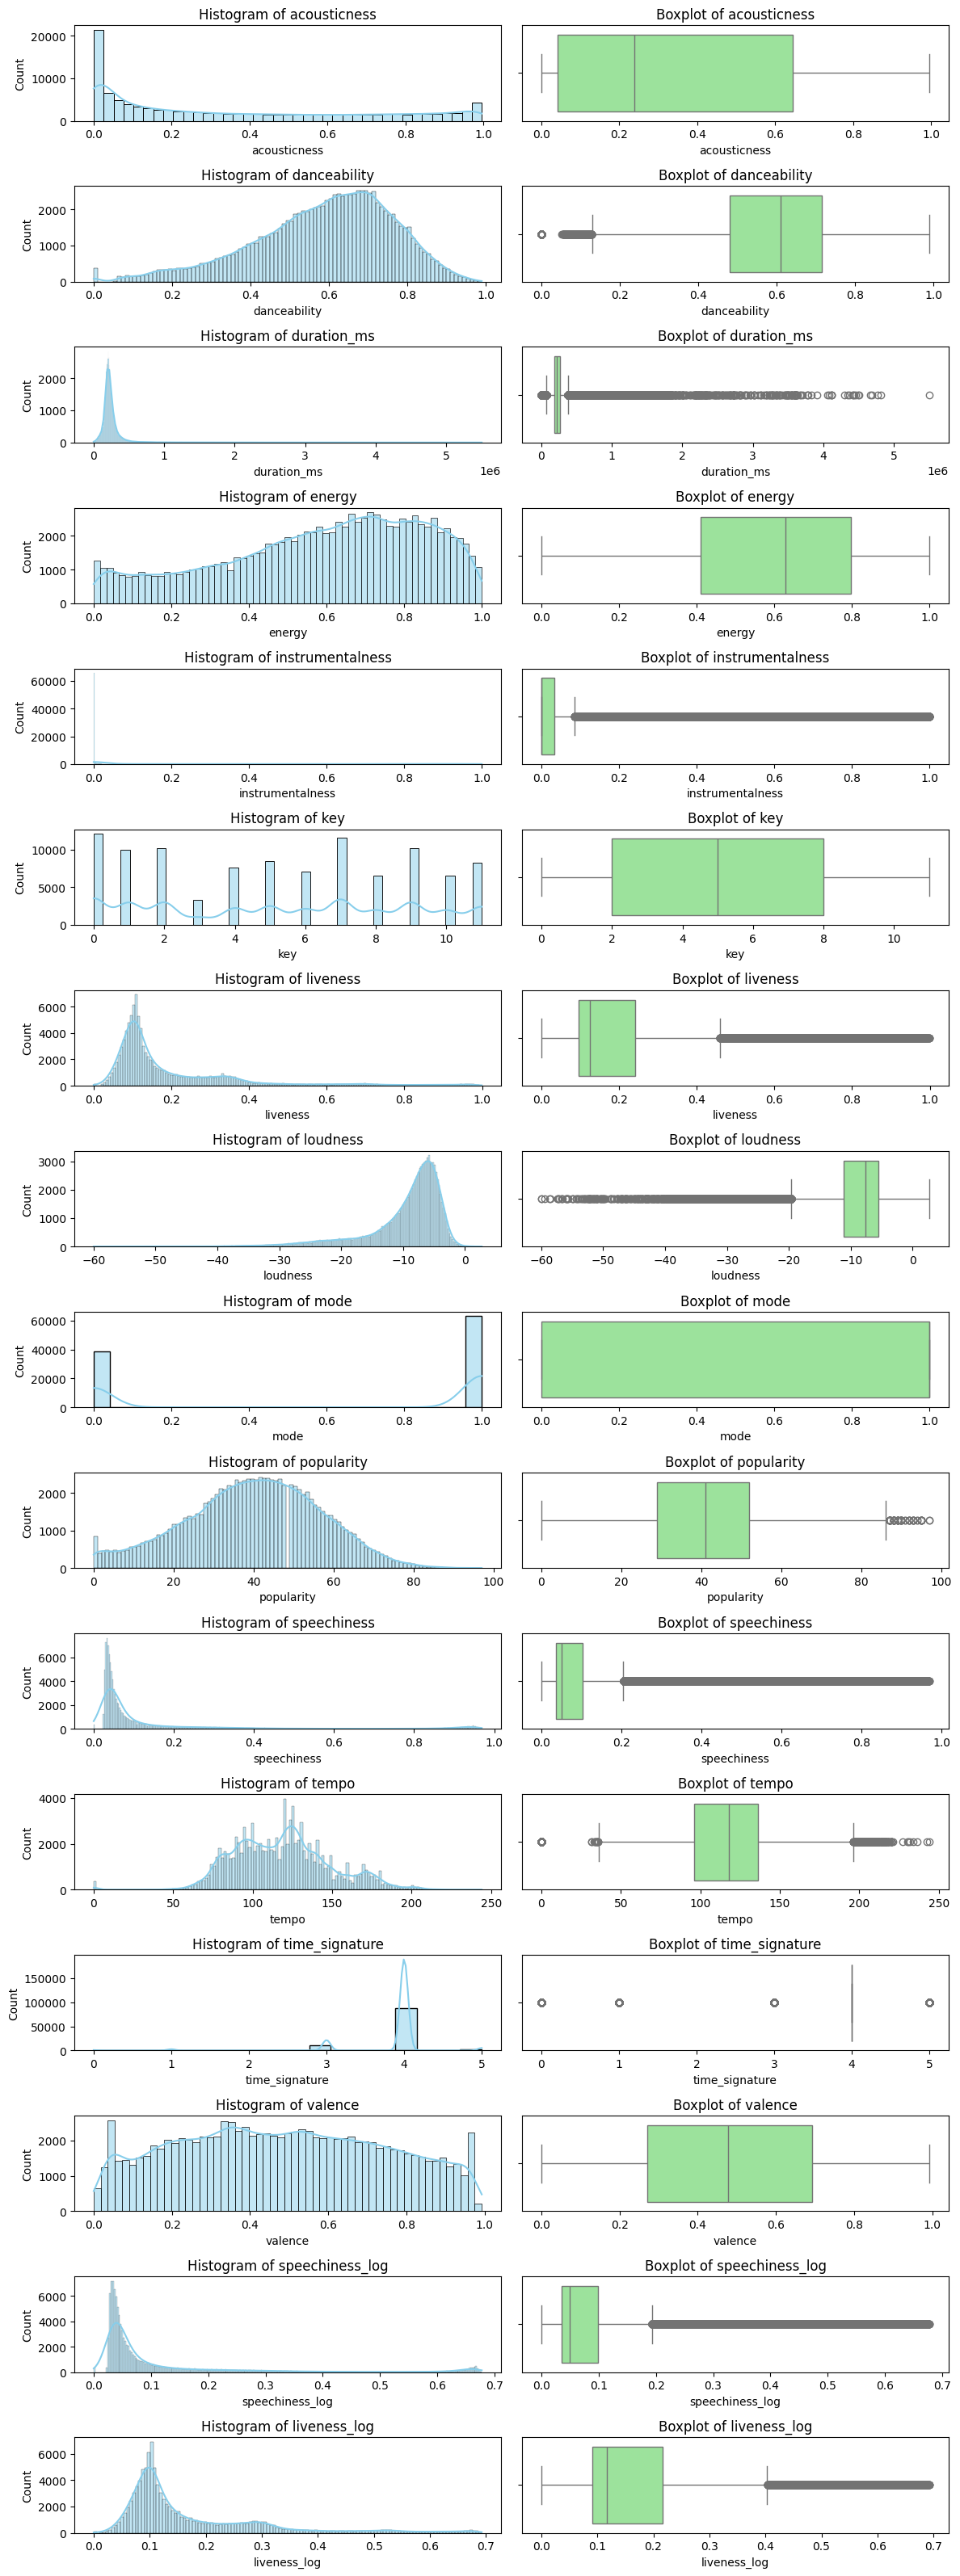

In [6]:
import numpy as np
df_m1["speechiness_log"] = np.log(df_m1[["speechiness"]]+1)
df_m1["liveness_log"] = np.log(df_m1[["liveness"]]+1)

makeEdaPlots(df_m1)

take only what we think really discriminate in Clusters to have good subsets. Then further using the rest of the fatures to calculate distance

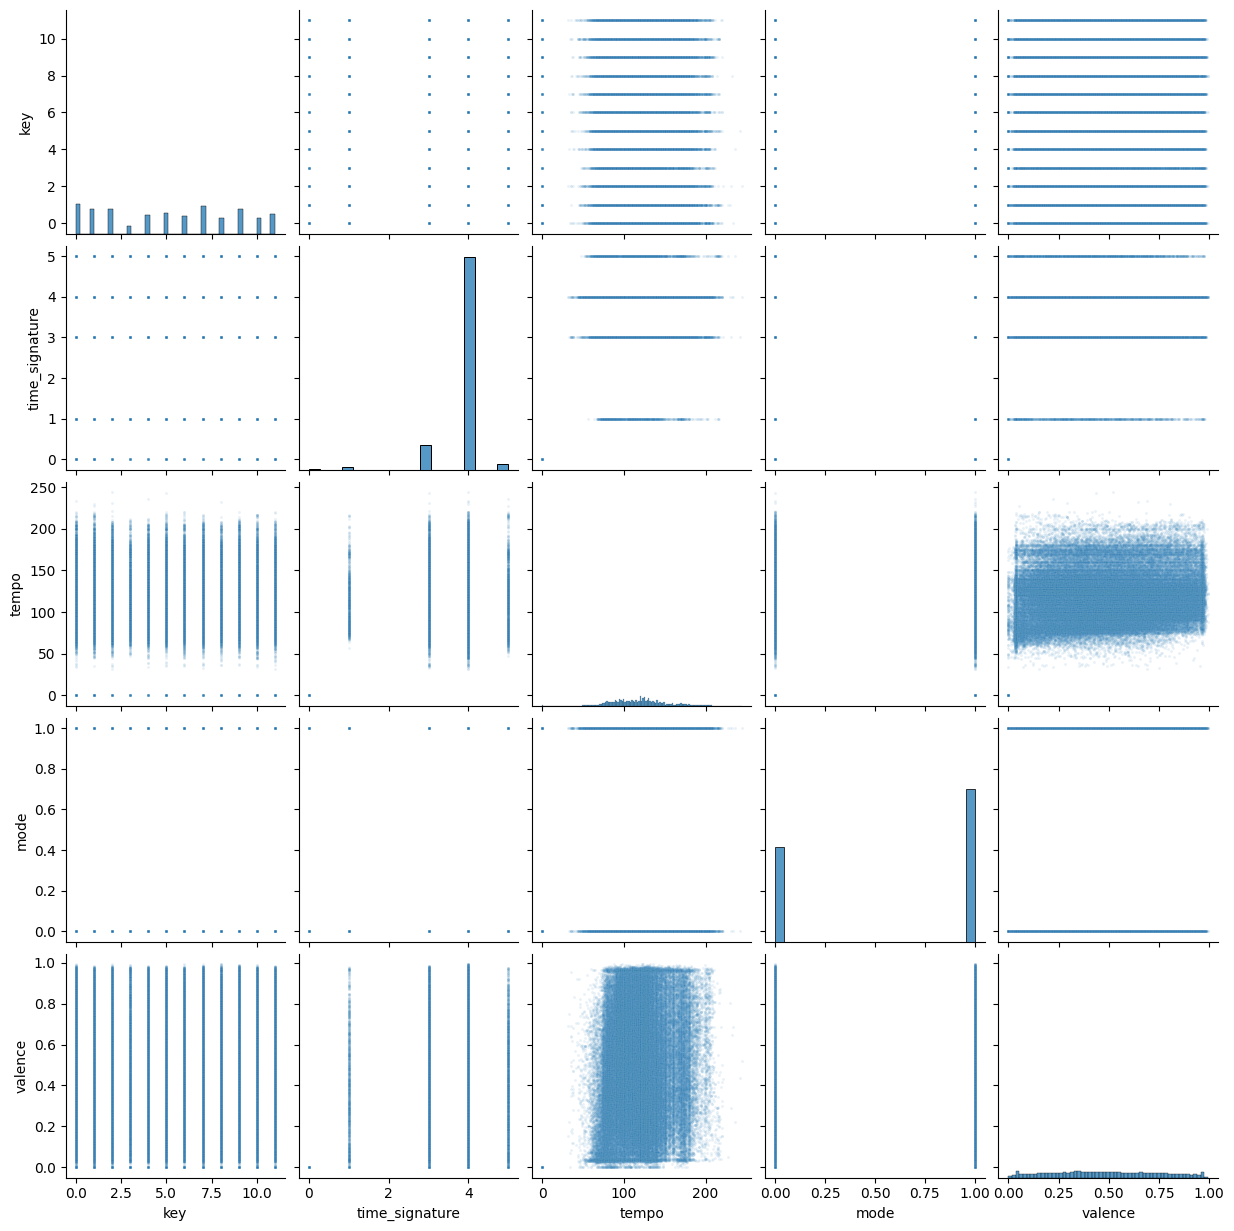

In [7]:
#df_m2 = df_m1[["key","time_signature","tempo","mode","acousticness"]]  52 1.1
#df_m2 = df_m1[["key","time_signature","tempo","mode"]] 1310 8.4
df_m2 = df_m1[["key","time_signature","tempo","mode","valence"]]  #60 0.7
#df_m2 = df_m1[["key","time_signature","tempo","mode","energy"]]  #51 0.7
sns.pairplot(df_m2,plot_kws={'alpha': 0.1, 's': 4})

In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler: Scales features to a fixed range [0, 1] — useful if your features are not Gaussian and you want to preserve sparsity or boundaries.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_m2)

In [9]:
import hdbscan
from hdbscan import validity


clusterer = hdbscan.HDBSCAN(

    min_cluster_size=30,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='eom',
    allow_single_cluster=False
)

labels = clusterer.fit_predict(X_scaled)

print(np.unique(labels, axis=0))
n_noise = np.sum(labels == -1)
print(f"Noise points: {n_noise} / {len(labels)} ({n_noise/len(labels)*100:.1f}%)")



[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
Noise points: 736 / 101939 (0.7%)


In [10]:
# Add this after the HDBSCAN clustering is complete
import pickle
import os

# Create directory for models if it doesn't exist
os.makedirs('../../data/models', exist_ok=True)

# Export HDBSCAN model
with open('../../data/models/hdbscan_model.pkl', 'wb') as f:
    pickle.dump(clusterer, f)
    
# Export cluster labels
with open('../../data/models/cluster_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

print("HDBSCAN model and cluster labels exported successfully!")

HDBSCAN model and cluster labels exported successfully!


In [11]:
score = validity.validity_index(X_scaled, labels, metric='euclidean')
print("DBCV Validity Score:", score)

DBCV Validity Score: -0.07187774509932619


In [12]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    n_components=2,
    metric='euclidean',
    random_state=42
)

embedding = reducer.fit_transform(X_scaled)

c:\Projects\Python_Project\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Projects\Python_Project\.conda\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


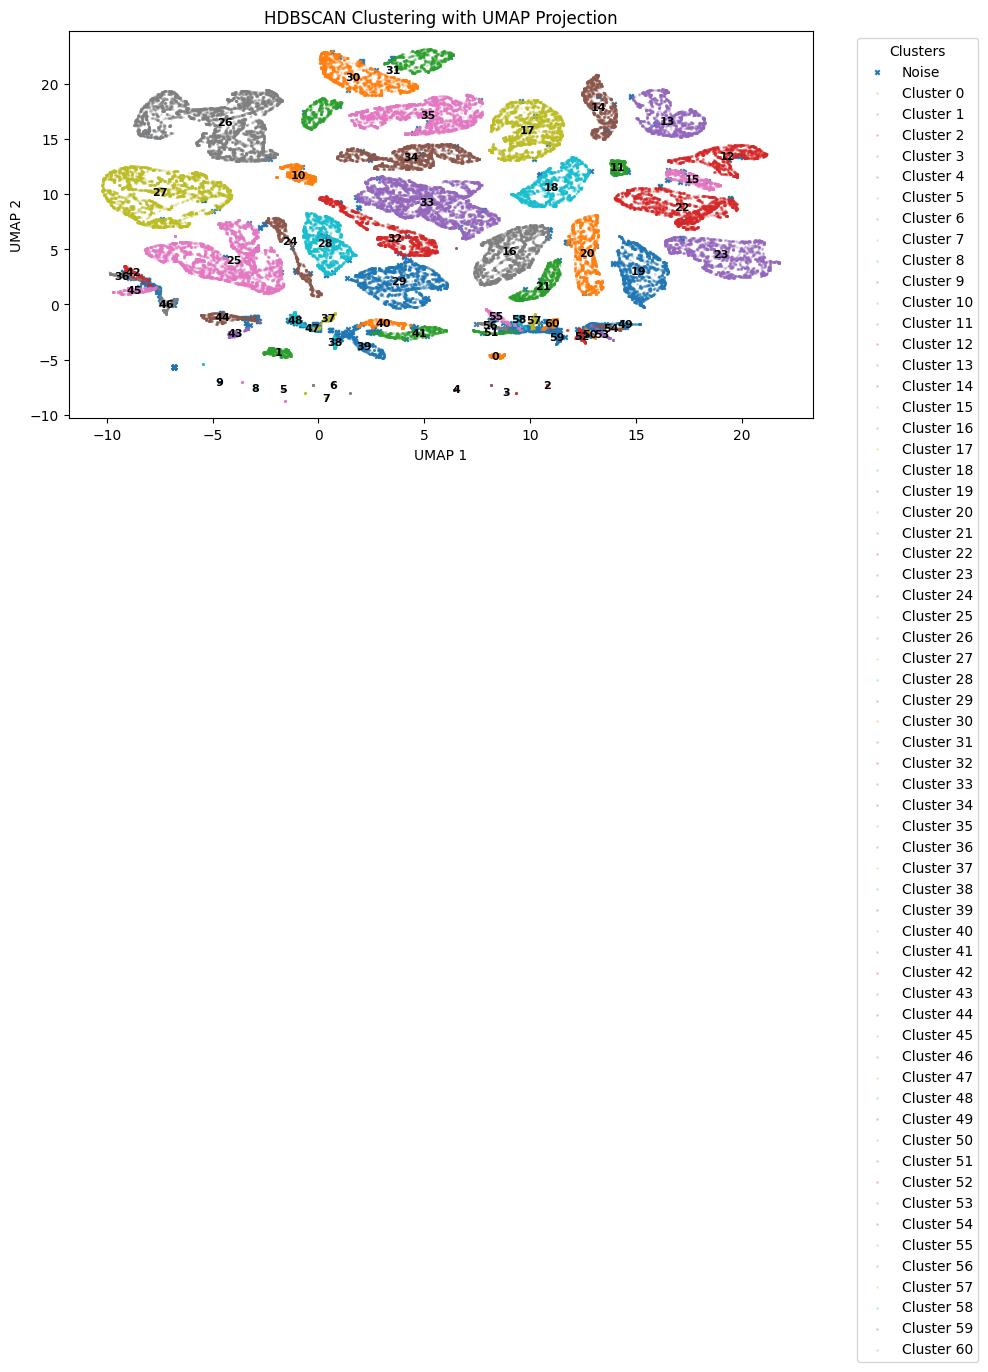

In [13]:

# Set up plot
plt.figure(figsize=(10, 10))
unique_labels = np.unique(labels)

for label in unique_labels:
    mask = labels == label
    marker = 'x' if label == -1 else '.'
    label_name = 'Noise' if label == -1 else f'Cluster {label}'

    plt.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        label=label_name,
        alpha=0.2 if label != -1 else 1,
        s=4 if label != -1 else 10,
        marker=marker
    )

    # Add cluster number at the median location (skip for noise)
    if label != -1:
        x_median = np.median(embedding[mask, 0])
        y_median = np.median(embedding[mask, 1])
        plt.text(x_median, y_median, str(label), fontsize=8, weight='bold', ha='center', va='center')

plt.title('HDBSCAN Clustering with UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

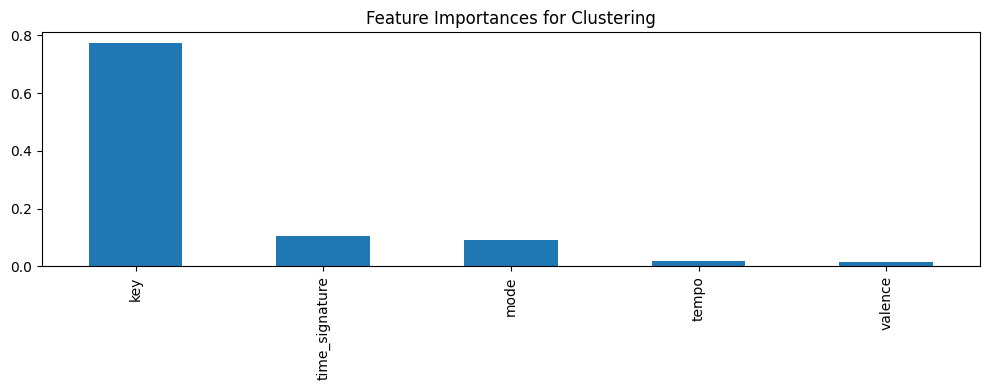

In [14]:
from sklearn.ensemble import RandomForestClassifier

df_m2_validate = df_m2.copy()
#df_m2_validate["labels"] = labels

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(df_m2_validate, labels)

importances = pd.Series(clf.feature_importances_, index=df_m2_validate.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), title="Feature Importances for Clustering")
plt.tight_layout()
plt.show()

## Adding the other Musical features for distance calculation

In [15]:

cluster_columns = list(df_m2.columns)
exclude = cluster_columns + ["speechiness_log", "liveness_log"]
#df_knn_naive = df_m1[[col for col in df_m1.columns if col not in exclude]]
df_knn_naive = df_m1.copy()
df_knn_naive.drop("duration_ms",inplace=True,axis=1)
df_knn_naive.drop("popularity",inplace=True,axis=1)
df_knn_naive.drop("speechiness_log",inplace=True,axis=1)
df_knn_naive.drop("liveness_log",inplace=True,axis=1)
df_knn_naive_scaled = pd.DataFrame(scaler.fit_transform(df_knn_naive), columns=df_knn_naive.columns)
df_knn_naive_scaled["label"] = labels
df_knn_naive_scaled.head()


,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
0,0.295181,0.705763,0.606,0.000003,0.909091,0.151151,0.837912,0.0,0.027038,0.471318,0.8,0.626385,18
1,0.866466,0.726997,0.308,0.000000,0.545455,0.253253,0.791786,1.0,0.951496,0.471551,0.6,0.593152,43
2,0.753012,0.471183,0.931,0.000000,0.363636,0.938939,0.739728,0.0,0.974200,0.326039,0.8,0.085599,22
3,0.766064,0.726997,0.126,0.000000,0.272727,0.113113,0.633715,0.0,0.968008,0.462319,0.6,0.536757,50
4,0.773092,0.465116,0.942,0.000000,0.636364,0.917918,0.737432,1.0,0.973168,0.332985,0.8,0.091239,33


In [16]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


def find_cluster_neighbors_from_df(df, song_idx, n_neighbors=6):
    """
    Given a DataFrame with scaled feature columns and a 'label' column,
    find the nearest neighbors within the same cluster for the song at song_idx.

    Parameters:
    - df: pandas DataFrame with scaled features and a 'label' column
    - song_idx: int, index of the song in df
    - n_neighbors: int, number of neighbors to find (including the song itself)

    Returns:
    - global_indices: indices of neighbors in the original DataFrame
    - distances: distances to these neighbors
    """

    # Extract features by dropping 'label'
    features = df.drop(columns=['label']).values

    # Get the cluster label of the song
    cluster_id = df.loc[song_idx, 'label']

    # Mask for points in the same cluster
    mask = df['label'] == cluster_id

    # Features for the cluster only
    cluster_features = features[mask]

    # Fit KNN on cluster features
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(cluster_features)

    # Query neighbors of the song's features
    distances, local_indices = knn.kneighbors([features[song_idx]])

    # Convert local cluster indices to global indices
    global_indices = np.where(mask)[0][local_indices[0]]

    return global_indices, distances[0]


# Example usage:
neighbors_idx, neighbors_dist = find_cluster_neighbors_from_df(df_knn_naive_scaled, song_idx=9999)

print("Distances:", neighbors_dist)
print("Neighbor labels:\n", df_knn_naive_scaled['label'].iloc[neighbors_idx])
print("Neighbor URIs:\n", df_spotify_tracks['uri'].iloc[neighbors_idx])
print("Neighbor Names:\n", df_spotify_tracks['name'].iloc[neighbors_idx])


Distances: [0.         0.20534843 0.20569431 0.21169591 0.21461128 0.22126083]
Neighbor labels:
 9999     34
49055    34
87728    34
35700    34
63941    34
18749    34
Name: label, dtype: int64
Neighbor URIs:
 9999     spotify:track:28AQJ5MzUv8P2ejrdtuaSI
49055    spotify:track:4s2F1KobBCl9Rs1TEhyxHT
87728    spotify:track:2CLv0oSPjs3vvwJWCJEu25
35700    spotify:track:1tD8ZRnUuBH1LkARmlxwMp
63941    spotify:track:1v8O6qnd7wgM5ipMgtzeaN
18749    spotify:track:6MShyf3EUHqQ04kJzovIni
Name: uri, dtype: object
Neighbor Names:
 9999            Universumi
49055    Homenagem à Folia
87728     Barndommens Gade
35700         Ole olemassa
63941         Dolor y Amor
18749              3e sexe
Name: name, dtype: object


## Testing different dataframes and feature combinantions with and without PCA

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

def find_neighbors_and_distances(df, song_idx, extra_info_df=None, n_neighbors=6):
    """
    Same function as before, returns distances and neighbor URIs.
    """
    features = df.drop(columns=['label']).values
    cluster_id = df.loc[song_idx, 'label']
    mask = df['label'] == cluster_id
    cluster_features = features[mask]
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(cluster_features)
    distances, local_indices = knn.kneighbors([features[song_idx]])
    global_indices = np.where(mask)[0][local_indices[0]]
    
    uris = None
    if extra_info_df is not None:
        uris = extra_info_df['uri'].iloc[global_indices].values
    
    return distances[0], uris


def compare_knn_across_dfs(dfs_dict, song_idx, extra_info_df, n_neighbors=6):
    """
    Runs KNN logic on multiple DataFrames and plots distance comparisons.
    
    Parameters:
    - dfs_dict: dict of name -> DataFrame (each with 'label' column + features)
    - song_idx: index of the song to query neighbors for
    - extra_info_df: DataFrame with 'uri' column aligned with dfs
    - n_neighbors: number of neighbors
    
    Returns:
    - neighbors_info_dict: dict with DataFrame names -> dict of 'uris' and 'distances'
    """
    
    neighbors_info_dict = {}
    plt.figure(figsize=(10,6))
    
    for name, df in dfs_dict.items():
        distances, uris = find_neighbors_and_distances(df, song_idx, extra_info_df, n_neighbors)
        
        neighbors_info_dict[name] = {
            'uris': uris,
            'distances': distances
        }

        plt.plot(range(1, n_neighbors + 1), distances, marker='o', label=name)
    
    plt.xlabel('Neighbor Rank')
    plt.ylabel('Distance')
    plt.title(f'KNN Neighbor Distances Comparison for Song Index {song_idx}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print URIs
    for name, info in neighbors_info_dict.items():
        print(f"\n🎵 Nearest Neighbors for '{name}':")
        for i, (uri, dist) in enumerate(zip(info['uris'], info['distances']), 1):
            print(f"{i}. URI: {uri} | Distance: {dist:.4f}")
    
    return neighbors_info_dict




### Generating a PCA with only the track songs

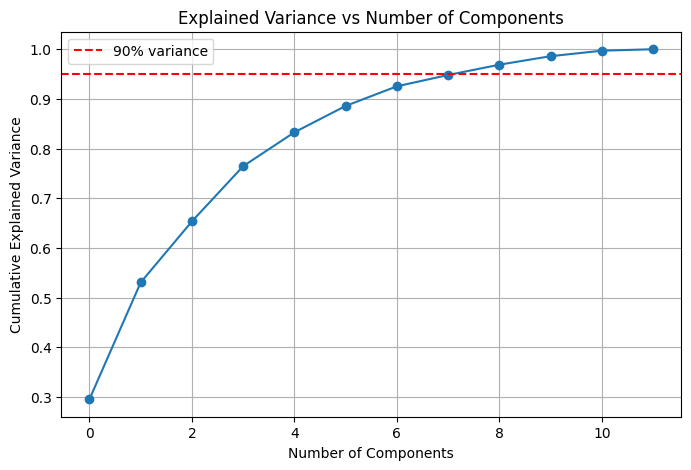

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,label
0,0.705027,-0.022002,-0.332116,-0.038059,0.045474,-0.158004,-0.013110,18
1,-0.460922,0.291449,-0.346355,-0.638238,0.097423,0.546865,-0.214850,43
2,0.506118,0.355889,0.098625,-0.479204,-0.448971,1.007146,0.448879,22
3,0.424775,0.603030,0.081140,-0.782932,0.042407,0.468945,-0.418246,50
4,-0.397969,0.129573,-0.322428,-0.312583,-0.437140,1.015022,0.428196,33


In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 2. Fit PCA without limiting components
pca = PCA()
df_knn_pca = df_knn_naive_scaled.iloc[:,:-1]
pca.fit(df_knn_pca)

# 3. Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='90% variance')
plt.legend()
plt.show()

# Step 2: Apply PCA
pca = PCA(n_components=7)
X_pca = pca.fit_transform(df_knn_pca)
# Create column names like 'pca_1', 'pca_2', ..., 'pca_6'
pca_columns = [f'pca_{i+1}' for i in range(X_pca.shape[1])]

# Create the DataFrame from the PCA result
df_knn_pca = pd.DataFrame(X_pca, columns=pca_columns, index=df_knn_pca.index)

# Optional: add back cluster labels or metadata
df_knn_pca['label'] = labels 
df_knn_pca.head()

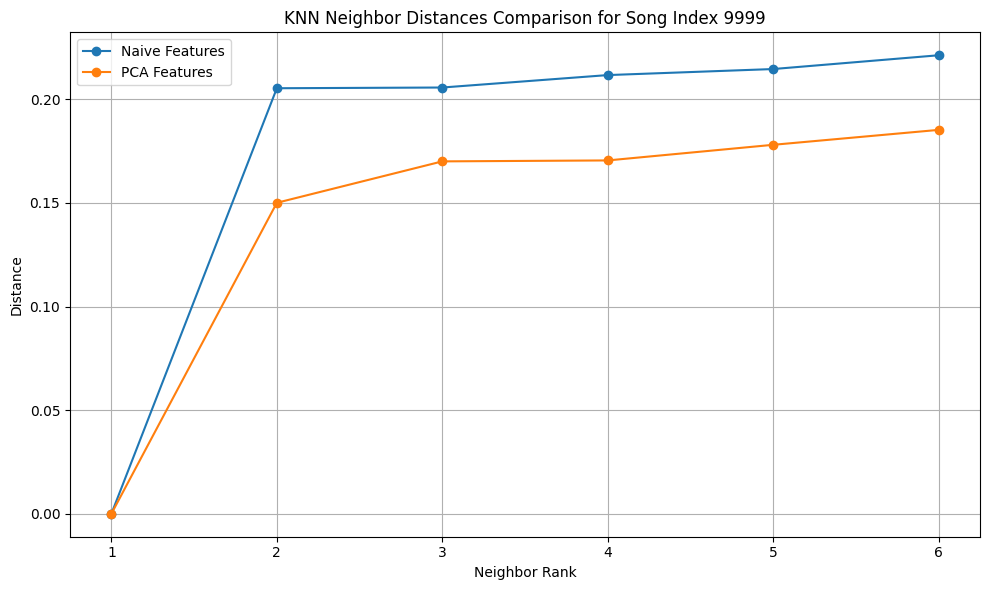


🎵 Nearest Neighbors for 'Naive Features':
1. URI: spotify:track:28AQJ5MzUv8P2ejrdtuaSI | Distance: 0.0000
2. URI: spotify:track:4s2F1KobBCl9Rs1TEhyxHT | Distance: 0.2053
3. URI: spotify:track:2CLv0oSPjs3vvwJWCJEu25 | Distance: 0.2057
4. URI: spotify:track:1tD8ZRnUuBH1LkARmlxwMp | Distance: 0.2117
5. URI: spotify:track:1v8O6qnd7wgM5ipMgtzeaN | Distance: 0.2146
6. URI: spotify:track:6MShyf3EUHqQ04kJzovIni | Distance: 0.2213

🎵 Nearest Neighbors for 'PCA Features':
1. URI: spotify:track:28AQJ5MzUv8P2ejrdtuaSI | Distance: 0.0000
2. URI: spotify:track:5li3FHS5s9V3l4xWsUcmQa | Distance: 0.1501
3. URI: spotify:track:2OuGyeEcLsGkuiO18wIWZY | Distance: 0.1701
4. URI: spotify:track:1tD8ZRnUuBH1LkARmlxwMp | Distance: 0.1705
5. URI: spotify:track:6MShyf3EUHqQ04kJzovIni | Distance: 0.1781
6. URI: spotify:track:1v8O6qnd7wgM5ipMgtzeaN | Distance: 0.1853


In [19]:
# Example usage:
# Suppose you have three DataFrames:
# df_naive, df_pca, df_modified each with a 'label' column and scaled features
dfs_to_compare = {
    'Naive Features': df_knn_naive_scaled,
    'PCA Features': df_knn_pca,
    #'Modified Features': df_knn_modified_scaled
}

neighbors_uris = compare_knn_across_dfs(dfs_to_compare, song_idx=9999, extra_info_df=df_spotify_tracks, n_neighbors=6)


### Using only the low level audio geatures inside the clusters

In [20]:
df_low_level_audio_feautures.head()
df_spotify_tracks["id"].head()

0    5qljLQuKnNJf4F4vfxQB0V
1    3VAX2MJdmdqARLSU5hPMpm
2    1L3YAhsEMrGVvCgDXj2TYn
3    6aCe9zzoZmCojX7bbgKKtf
4    1Vo802A38tPFHmje1h91um
Name: id, dtype: object

In [21]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 1. Merge features and labels
df_temp = df_spotify_tracks.copy()
df_temp["label"] = labels
df_knn_llav_naive = pd.merge(
    df_temp[["id", "label"]],
    df_low_level_audio_feautures,
    how="left",
    left_on="id",
    right_on="track_id"
)

# 2. Drop unnecessary columns
df_knn_llav_naive.drop(columns=["id", "track_id", "Unnamed: 0"], inplace=True)

# 3. Impute missing values
imputer = KNNImputer(n_neighbors=30)
df_knn_llav_naive_imputed = pd.DataFrame(
    imputer.fit_transform(df_knn_llav_naive),
    columns=df_knn_llav_naive.columns,
    index=df_knn_llav_naive.index
)

# 4. Separate label
features = df_knn_llav_naive_imputed.drop(columns=['label'])
labels = df_knn_llav_naive_imputed['label']

# 5. Scale features only
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 6. Create scaled DataFrame
df_knn_llav_naive_scaled = pd.DataFrame(
    features_scaled,
    columns=features.columns,
    index=features.index
)

# 7. Add label back
df_knn_llav_naive_scaled['label'] = labels

# ✅ Done
df_knn_llav_naive_scaled.head()




,Chroma_1,Chroma_10,Chroma_11,Chroma_12,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,Chroma_7,...,Tonnetz_4,Tonnetz_5,Tonnetz_6,ZCR,entropy_energy,spectral_bandwith,spectral_centroid,spectral_rollOff_max,spectral_rollOff_min,label
0,0.353348,0.488285,0.525691,0.380601,0.384341,0.445430,0.574834,0.511173,0.502670,0.525849,...,0.464210,0.653851,0.556113,0.116717,0.481041,0.367353,0.189307,0.260220,0.020904,18.0
1,0.340826,0.401041,0.391372,0.376835,0.333859,0.405734,0.439690,0.418082,0.409951,0.426179,...,0.490011,0.622159,0.534709,0.147107,0.482496,0.288977,0.122752,0.212240,0.066560,43.0
2,0.520637,0.595655,0.544120,0.533902,0.537103,0.575602,0.605169,0.629450,0.635940,0.650860,...,0.509378,0.628298,0.529536,0.203348,0.602614,0.338632,0.200862,0.275782,0.075456,22.0
3,0.455442,0.481004,0.462307,0.448513,0.409725,0.412737,0.432610,0.452711,0.457471,0.453674,...,0.513121,0.637030,0.530586,0.203912,0.649171,0.428011,0.102898,0.324419,0.105554,50.0
4,0.550698,0.611000,0.595551,0.593463,0.563438,0.575980,0.581886,0.591356,0.600857,0.621317,...,0.499880,0.628278,0.519729,0.210259,0.613917,0.348286,0.244577,0.278564,0.076767,33.0


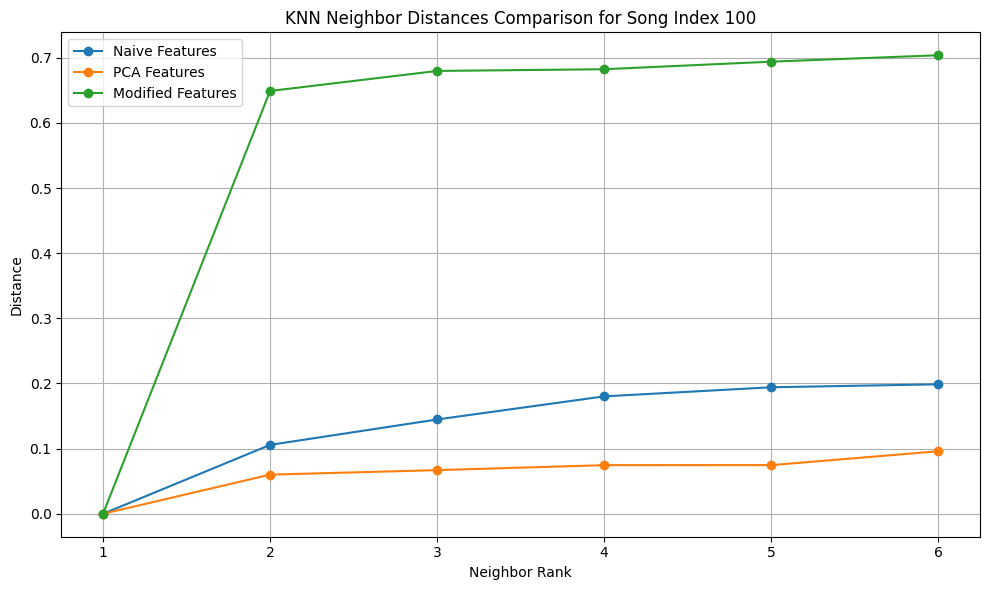


🎵 Nearest Neighbors for 'Naive Features':
1. URI: spotify:track:7afpDI6k8fFpRuqEYFMxqR | Distance: 0.0000
2. URI: spotify:track:5Ko8Lcb48iK4lazKCleQ9t | Distance: 0.1057
3. URI: spotify:track:2XJCThaQQPWv9HHY3SCaU5 | Distance: 0.1448
4. URI: spotify:track:1ZzSTURCWH0Xax2i69ooSE | Distance: 0.1802
5. URI: spotify:track:34JBZjGLUZonoqFjtbC31v | Distance: 0.1942
6. URI: spotify:track:3EUl8M6SzxZl03NPkB8mUd | Distance: 0.1987

🎵 Nearest Neighbors for 'PCA Features':
1. URI: spotify:track:7afpDI6k8fFpRuqEYFMxqR | Distance: 0.0000
2. URI: spotify:track:5Ko8Lcb48iK4lazKCleQ9t | Distance: 0.0601
3. URI: spotify:track:5fghXy9xCMweLOu6kQgAul | Distance: 0.0670
4. URI: spotify:track:3PzZNV9AANQ1VFs80IHOEx | Distance: 0.0746
5. URI: spotify:track:4p5jLUvSnWQnzK5ME1zUxj | Distance: 0.0747
6. URI: spotify:track:16mkBANSMk7sLvN5840WK8 | Distance: 0.0960

🎵 Nearest Neighbors for 'Modified Features':
1. URI: spotify:track:7afpDI6k8fFpRuqEYFMxqR | Distance: 0.0000
2. URI: spotify:track:2Kuyu50utO4HJJjY

In [22]:
# Example usage:
# Suppose you have three DataFrames:
# df_naive, df_pca, df_modified each with a 'label' column and scaled features
dfs_to_compare = {
    'Naive Features': df_knn_naive_scaled,
    'PCA Features': df_knn_pca,
    'Modified Features': df_knn_llav_naive_scaled
}

neighbors_uris = compare_knn_across_dfs(dfs_to_compare, song_idx=100, extra_info_df=df_spotify_tracks, n_neighbors=6)



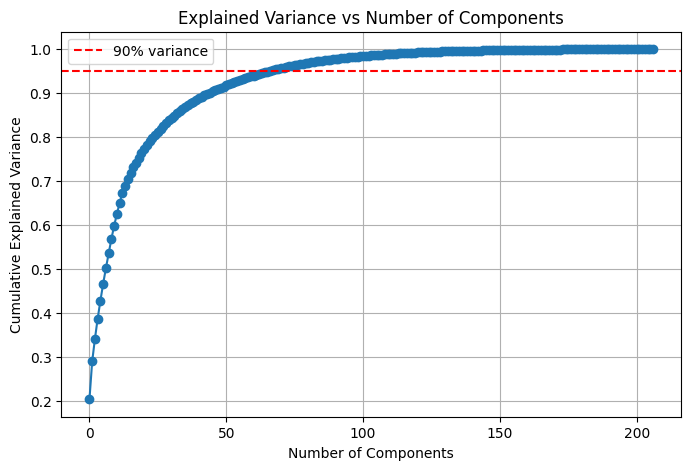

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,label
0,-0.093130,0.017553,0.010078,0.035441,0.033607,-0.148140,0.029571,-0.067568,0.125935,0.082217,...,-0.030625,0.006061,-0.032708,0.045063,-0.022788,-0.049573,-0.009721,-0.053871,0.013796,18.0
1,-0.511688,0.111287,0.183830,-0.114889,-0.040270,0.009272,-0.030439,-0.101198,-0.122108,0.131848,...,-0.016978,-0.021131,0.032121,-0.008346,-0.052381,0.005420,0.001471,-0.023460,-0.017780,43.0
2,-0.117658,-0.566313,-0.043011,0.043151,-0.104145,-0.067826,0.045479,-0.121293,-0.046337,0.098897,...,0.016087,-0.023607,-0.017920,0.026058,-0.017682,-0.006432,0.001338,0.004095,0.001729,22.0
3,-0.385583,-0.066524,-0.166909,0.051201,-0.166606,0.251721,0.011656,0.013815,-0.026920,0.103637,...,-0.002126,0.022753,0.024191,-0.002027,0.006260,0.018280,-0.004796,-0.021704,-0.021795,50.0
4,-0.044471,-0.574119,-0.027388,-0.040177,-0.101332,-0.005342,-0.002311,-0.039491,-0.060748,0.092082,...,0.024444,-0.041736,0.004244,0.007573,-0.003159,-0.003217,0.010992,-0.001931,0.012602,33.0


In [23]:
# 2. Fit PCA without limiting components
pca = PCA()
df_knn_llav_pca = df_knn_llav_naive_scaled.iloc[:,:-1]
pca.fit(df_knn_llav_pca)

# 3. Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='90% variance')
plt.legend()
plt.show()

# Step 2: Apply PCA
pca = PCA(n_components=60)
X_pca = pca.fit_transform(df_knn_llav_pca)
# Create column names like 'pca_1', 'pca_2', ..., 'pca_6'
pca_columns = [f'pca_{i+1}' for i in range(X_pca.shape[1])]

# Create the DataFrame from the PCA result
df_knn_llav_pca = pd.DataFrame(X_pca, columns=pca_columns, index=df_knn_llav_pca.index)

# Optional: add back cluster labels or metadata
df_knn_llav_pca['label'] = labels 
df_knn_llav_pca.head()


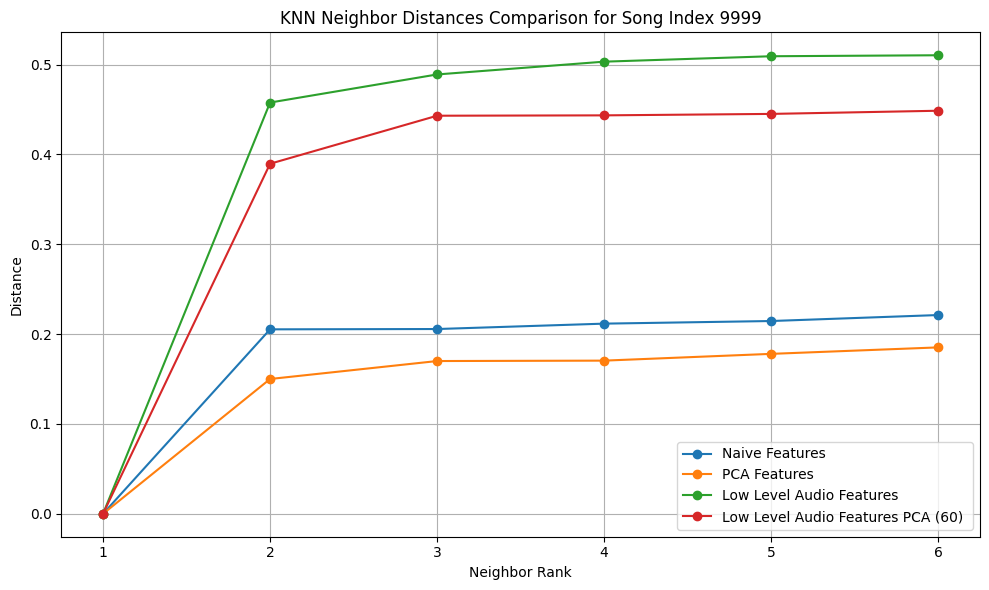


🎵 Nearest Neighbors for 'Naive Features':
1. URI: spotify:track:28AQJ5MzUv8P2ejrdtuaSI | Distance: 0.0000
2. URI: spotify:track:4s2F1KobBCl9Rs1TEhyxHT | Distance: 0.2053
3. URI: spotify:track:2CLv0oSPjs3vvwJWCJEu25 | Distance: 0.2057
4. URI: spotify:track:1tD8ZRnUuBH1LkARmlxwMp | Distance: 0.2117
5. URI: spotify:track:1v8O6qnd7wgM5ipMgtzeaN | Distance: 0.2146
6. URI: spotify:track:6MShyf3EUHqQ04kJzovIni | Distance: 0.2213

🎵 Nearest Neighbors for 'PCA Features':
1. URI: spotify:track:28AQJ5MzUv8P2ejrdtuaSI | Distance: 0.0000
2. URI: spotify:track:5li3FHS5s9V3l4xWsUcmQa | Distance: 0.1501
3. URI: spotify:track:2OuGyeEcLsGkuiO18wIWZY | Distance: 0.1701
4. URI: spotify:track:1tD8ZRnUuBH1LkARmlxwMp | Distance: 0.1705
5. URI: spotify:track:6MShyf3EUHqQ04kJzovIni | Distance: 0.1781
6. URI: spotify:track:1v8O6qnd7wgM5ipMgtzeaN | Distance: 0.1853

🎵 Nearest Neighbors for 'Low Level Audio Features':
1. URI: spotify:track:28AQJ5MzUv8P2ejrdtuaSI | Distance: 0.0000
2. URI: spotify:track:3wogsSWyE

In [24]:
# Example usage:
# Suppose you have three DataFrames:
# df_naive, df_pca, df_modified each with a 'label' column and scaled features
dfs_to_compare = {
    'Naive Features': df_knn_naive_scaled,
    'PCA Features': df_knn_pca,
    'Low Level Audio Features': df_knn_llav_naive_scaled,
    'Low Level Audio Features PCA (60) ': df_knn_llav_pca
}

neighbors_uris = compare_knn_across_dfs(dfs_to_compare, song_idx=9999, extra_info_df=df_spotify_tracks, n_neighbors=6)


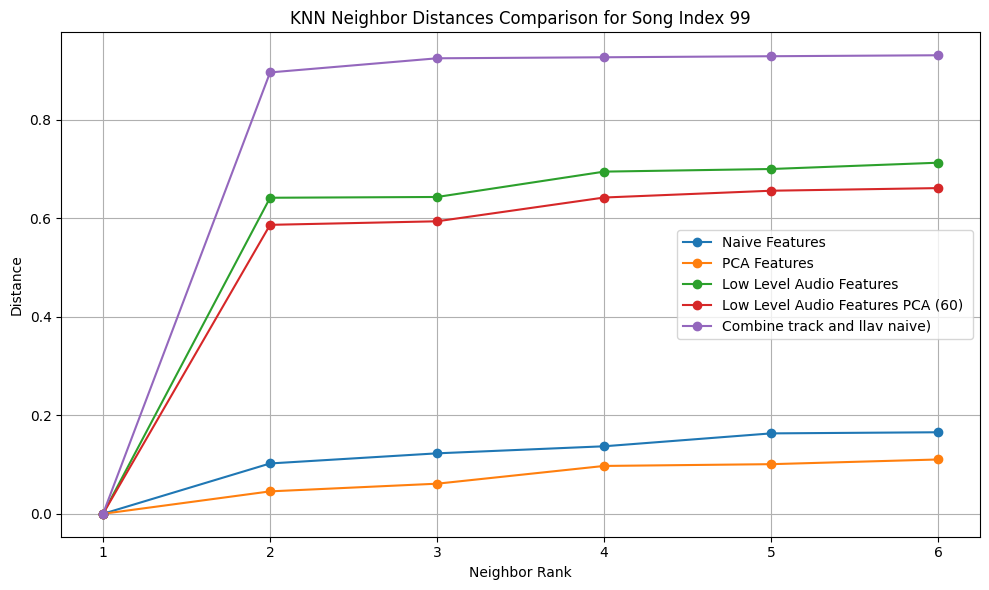


🎵 Nearest Neighbors for 'Naive Features':
1. URI: spotify:track:0ZBPWoRkfZ8SLcDJaFnkUu | Distance: 0.0000
2. URI: spotify:track:6wcXJAcykFFNlZfX6H1mxJ | Distance: 0.1022
3. URI: spotify:track:50L4TGtO5U2MktfsHDfXSA | Distance: 0.1227
4. URI: spotify:track:1Xi5DMQHqLP0RIdLEfsi20 | Distance: 0.1370
5. URI: spotify:track:3X1EpASwYMAWRwi9WpvFTe | Distance: 0.1632
6. URI: spotify:track:4wCGQO0Y0vIPiglFCbUOQV | Distance: 0.1655

🎵 Nearest Neighbors for 'PCA Features':
1. URI: spotify:track:0ZBPWoRkfZ8SLcDJaFnkUu | Distance: 0.0000
2. URI: spotify:track:6wcXJAcykFFNlZfX6H1mxJ | Distance: 0.0455
3. URI: spotify:track:1Xi5DMQHqLP0RIdLEfsi20 | Distance: 0.0611
4. URI: spotify:track:3X1EpASwYMAWRwi9WpvFTe | Distance: 0.0971
5. URI: spotify:track:50L4TGtO5U2MktfsHDfXSA | Distance: 0.1007
6. URI: spotify:track:4wCGQO0Y0vIPiglFCbUOQV | Distance: 0.1102

🎵 Nearest Neighbors for 'Low Level Audio Features':
1. URI: spotify:track:0ZBPWoRkfZ8SLcDJaFnkUu | Distance: 0.0000
2. URI: spotify:track:3jzg268xM

In [25]:
#combis
df_track_naive_plus_llav = pd.concat([df_knn_naive_scaled, df_knn_llav_naive_scaled.iloc[:, :-1]], axis=1)

dfs_to_compare = {
    'Naive Features': df_knn_naive_scaled,
    'PCA Features': df_knn_pca,
    'Low Level Audio Features': df_knn_llav_naive_scaled,
    'Low Level Audio Features PCA (60) ': df_knn_llav_pca,
    'Combine track and llav naive) ': df_track_naive_plus_llav
}

neighbors_uris = compare_knn_across_dfs(dfs_to_compare, song_idx=99, extra_info_df=df_spotify_tracks, n_neighbors=6)


In [27]:
# Export final models and embeddings after comparing all approaches

# Determine which feature set performed best
# Based on the notebook analysis, let's assume Low Level Audio Features PCA is the best
best_features_df = df_knn_llav_pca.copy()
best_features = best_features_df.drop(columns=['label']).values

# Create final KNN model on best features
from sklearn.neighbors import NearestNeighbors
final_knn = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean')
final_knn.fit(best_features)

# Export KNN model
with open('../../data/models/knn_model.pkl', 'wb') as f:
    pickle.dump(final_knn, f)

# Export feature embeddings
with open('../../data/models/audio_embeddings.pkl', 'wb') as f:
    pickle.dump(best_features, f)

# Export song index mapping (to connect embeddings back to tracks)
song_indices = {
    'track_ids': df_spotify_tracks['id'].values,
    'track_names': df_spotify_tracks['name'].values,
    'track_artists': df_spotify_tracks['artists_id'].values,
    'track_uris': df_spotify_tracks['uri'].values
}
with open('../../data/models/song_indices.pkl', 'wb') as f:
    pickle.dump(song_indices, f)

print("Final KNN model, embeddings, and song indices exported successfully!")

Final KNN model, embeddings, and song indices exported successfully!


In [29]:
df_m2_validate.head()

,key,time_signature,tempo,mode,valence
0,10.0,4.0,115.018,0.0,0.6220
1,6.0,3.0,115.075,1.0,0.5890
2,4.0,4.0,79.565,0.0,0.0850
3,3.0,3.0,112.822,0.0,0.5330
4,7.0,4.0,81.260,1.0,0.0906


In [28]:
df_m2_validate[df_m2_validate["labels"] == labels[idx]].describe()

KeyError: 'labels'

In [30]:
df_low_level_audio_feautures.head()

,Unnamed: 0,Chroma_1,Chroma_10,Chroma_11,Chroma_12,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,...,Tonnetz_4,Tonnetz_5,Tonnetz_6,ZCR,entropy_energy,spectral_bandwith,spectral_centroid,spectral_rollOff_max,spectral_rollOff_min,track_id
0,0,0.438296,0.472769,0.427441,0.436688,0.467697,0.493862,0.512244,0.568658,0.560524,...,0.018434,-0.001759,-0.006392,0.067966,-89.113389,2564.247669,3558.400706,4508.506071,367.831109,19YEk4OVQZn3GfoxbpNrU6
1,1,0.596605,0.368288,0.285263,0.302211,0.905805,0.510909,0.221708,0.311248,0.491277,...,0.046941,0.005665,-0.026928,0.047308,-127.945239,2370.181495,1499.689590,3647.394611,230.165275,6zJms3MX11Qu1IKF44LoRW
2,2,0.505224,0.500420,0.506773,0.488258,0.498356,0.573582,0.690761,0.742858,0.686282,...,-0.006929,0.004968,0.008947,0.058463,-238.285176,2973.294736,1543.550034,5623.349330,187.290534,1WugzepXsLjnsM0K4UaWYc
3,3,0.525690,0.666469,0.579492,0.498920,0.598528,0.631578,0.501693,0.500468,0.587101,...,-0.027382,-0.009689,0.001402,0.080547,-148.785733,2716.749483,3017.248824,5799.931595,160.940693,1pSlTbCrUJ9rmwj5CNNrX4
4,4,0.632214,0.503698,0.496942,0.611532,0.634613,0.697265,0.557012,0.530836,0.444279,...,0.003728,-0.002780,-0.010120,0.084945,-176.618314,3096.692876,2118.686992,6560.018666,229.131948,5yruvWJs3mL00w4slpCVzN


In [31]:
df_m3 =df_spotify_tracks.copy()
df_m3["label"] = labels

df_m3_2 = pd.merge(df_m3[["id","label"]], df_low_level_audio_feautures, how="left", left_on='id',right_on="track_id")
df_m3_2.drop(columns=['id', 'track_id',"Unnamed: 0"], inplace=True)
df_m3_2.dropna(inplace=True)
df_m3_2.head()

,label,Chroma_1,Chroma_10,Chroma_11,Chroma_12,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,...,Tonnetz_3,Tonnetz_4,Tonnetz_5,Tonnetz_6,ZCR,entropy_energy,spectral_bandwith,spectral_centroid,spectral_rollOff_max,spectral_rollOff_min
0,18.0,0.375300,0.494234,0.531019,0.387172,0.405119,0.456896,0.581946,0.515139,0.506039,...,0.005286,-0.027299,0.005772,0.008440,0.046804,-182.945630,2571.486199,2087.112746,4485.181212,131.157540
1,43.0,0.363204,0.408007,0.398208,0.383447,0.356340,0.418021,0.449081,0.422803,0.414066,...,0.018002,-0.007843,-0.001622,0.002142,0.058261,-182.432736,2091.303337,1353.341469,3686.694374,416.947479
2,22.0,0.536910,0.600352,0.549241,0.538813,0.552725,0.584377,0.611770,0.632456,0.638238,...,0.001951,0.006761,-0.000190,0.000619,0.079464,-140.088824,2395.523374,2214.499532,4744.154646,472.630475
3,50.0,0.473929,0.487038,0.468347,0.454349,0.429646,0.424879,0.442119,0.457151,0.461204,...,0.000552,0.009583,0.001847,0.000928,0.079677,-123.676940,2943.121479,1134.452723,5553.574752,661.029336
4,33.0,0.565951,0.615518,0.600094,0.597729,0.578171,0.584746,0.588880,0.594671,0.603436,...,0.005916,-0.000402,-0.000195,-0.002266,0.082069,-136.104429,2454.667943,2696.457022,4790.462699,480.838759


In [32]:
scaler = MinMaxScaler()
X_scaled_full = scaler.fit_transform(df_m3_2)

In [33]:
from sklearn.neighbors import NearestNeighbors
idx = 41145
# Assume: you have `X`, `labels`, and `embedding` (from UMAP)
cluster_id = df_m3_2.iloc[idx]["label"]  # idx = your song index
# Get points in the same cluster
mask = df_m3_2["label"] == cluster_id
X_cluster = X_scaled_full[mask]  # or X_scaled[mask]

# Fit KNN only on this cluster
knn = NearestNeighbors(n_neighbors=6).fit(X_cluster)
distances, indices = knn.kneighbors([X_scaled_full[idx]])

# Convert local indices to global
global_indices = np.where(mask)[0][indices[0]]
print(distances)
print(global_indices)

print(df_m3_2["label"].iloc[global_indices])

print(df_spotify_tracks["uri"].iloc[global_indices])

[[0.         0.63321895 0.63443993 0.66075286 0.67473897 0.67827778]]
[41145 90271 73482 90049 46245 66225]
41157    25.0
90299    25.0
73505    25.0
90077    25.0
46259    25.0
66246    25.0
Name: label, dtype: float64
41145    spotify:track:7Hy7mQDiMuTXacDe8Fzqsg
90271    spotify:track:4tIIRx9NG4Nyu53Xt9e8C3
73482    spotify:track:4iQz1P9aPfJoY4Vbc6roLY
90049    spotify:track:6qP73DRFGojLuIk1siIhNE
46245    spotify:track:0G9ZWtLoEEbFRhC1NXfaWL
66225    spotify:track:1qd14t933fsUNyvdiJ180T
Name: uri, dtype: object


In [34]:
# Test loading the exported models

# Load models
with open('../../data/models/hdbscan_model.pkl', 'rb') as f:
    loaded_hdbscan = pickle.load(f)
    
with open('../../data/models/knn_model.pkl', 'rb') as f:
    loaded_knn = pickle.load(f)
    
with open('../../data/models/audio_embeddings.pkl', 'rb') as f:
    loaded_embeddings = pickle.load(f)
    
with open('../../data/models/song_indices.pkl', 'rb') as f:
    loaded_indices = pickle.load(f)

# Test recommendation for a sample song
sample_idx = 41145  # Choose any valid index
sample_embedding = loaded_embeddings[sample_idx].reshape(1, -1)

# Get recommendations
distances, indices = loaded_knn.kneighbors(sample_embedding, n_neighbors=6)

# Display results
print("Sample song:", loaded_indices['track_names'][sample_idx], "by", loaded_indices['track_artists'][sample_idx])
print("\nRecommended songs:")
for i, idx in enumerate(indices[0][1:]):  # Skip first result (it's the same song)
    print(f"{i+1}. {loaded_indices['track_names'][idx]} by {loaded_indices['track_artists'][idx]} (Distance: {distances[0][i+1]:.4f})")

Sample song: H.N. by ['4CvsUCqrOaQBLUV5la9pMa']

Recommended songs:
1. Colony Theme by ['12BDNYhvDp2RIeF9pabPzv'] (Distance: 0.6529)
2. Songs Without Words by ['356DaKT7lQvmKRHIOIYQY3'] (Distance: 0.7162)
3. Psalm 41 "Quemadmodum" by ['0ZGj6vmZUz4vk80EfPLjxP', '5pm2guT1Q7tF7ATiUnQhg6'] (Distance: 0.7206)
4. Soliloquy by ['3BC3jPO6EpRTy6iySniyZH'] (Distance: 0.7501)
5. Don't Let Me Down (Instrumental) by ['4TCXgdDPm10ensLNCVnIYa'] (Distance: 0.7596)
